In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import random

from obspy import read

In [40]:
signal_samples = 301# 301
station_count = 1#38
time_arr = np.linspace(0.0, 30.0, signal_samples)
time_arr.shape

(301,)

In [41]:
# plot wave normal
def plot_wave_processed(data):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, len(data))]
    i = 0
    for s in data:
        ax.plot(time_arr, s, color=colors[i])
        i+=1
    ax.tick_params(axis='both', labelsize=15)
    ax.tick_params(axis='both', labelsize=15)
    plt.ylabel('HHZ Velocity', fontsize=20)
    plt.xlabel('Timestep', fontsize=20);
    plt.grid()
    plt.show()
    del fig
    del ax

In [42]:
# READING NORMAL BEHAVIOUR
pkl_file = open('../datasets/normal/waveforms/100hz/normal_seismic_100hz.pkl', 'rb')
normal_data = pickle.load(pkl_file)
pkl_file.close()
(len(normal_data), len(normal_data[0]), len(normal_data[0][0]))

(12447, 1, 301)

In [43]:
# READING activbe BEHAVIOUR
pkl_file = open('../datasets/active/waveforms/100hz/normal_seismic_100hz.pkl', 'rb')
earthquakes_data = pickle.load(pkl_file)
pkl_file.close()
#earthquakes_data = earthquakes_data[0:3000]
(len(earthquakes_data), len(earthquakes_data[0]), len(earthquakes_data[0][0]))

(1403, 1, 301)

In [44]:
plot_wave_processed([earthquakes_data[0][0], normal_data[0][10], earthquakes_data[13][0]]) #, normal_data[0][0]
plot_wave_processed(earthquakes_data[15])

IndexError: index 10 is out of bounds for axis 0 with size 1

In [45]:
#def filter_data(data):
#    # check for possible nans and incomplete station data
#    
#    for i in range(0, len(data)):
#        stations = data[i]
#        if len(stations) != station_count:
#            
#        for d in range(0, data[i]):
#            print()

def check_nans_incomplete_stations(data):
    
    # check for possible nans and incomplete station data
    nan_arr = []
    not_58_stations = []
    not_61_samples = []

    for i in range(0, len(data)):
        
        try:
            # stations != 58 per event
            if len(data[i]) != station_count:
                not_58_stations.append(i)
                
            for j in range(0, station_count):
                
                try:
                    if len(data[i][j]) != signal_samples:
                        not_61_samples.append(i)
                # a station has nan value(s)
                    
                    is_nan_event = np.isnan(np.sum(data[i][j]))
                    if is_nan_event:
                        nan_arr.append(i)
                    
                except:
                    print(len(data[i]))
                    not_61_samples.append(i)
                
        except:
            print(len(data[i]))
            not_58_stations.append(i)
            
        
                
    return nan_arr, not_58_stations, not_61_samples

# verify that we only have one shape for stations and samples
def verify_unique_shapes(data):
    stations_shape = [station_count]
    samples_shape = [signal_samples]
    
    for i in data:
        station_shape = len(i)
    
        if station_shape not in stations_shape:
            stations_shape.append(station_shape)
            
        for j in i:
            sample_shape = len(j)
            if sample_shape not in samples_shape:
                samples_shape.append(sample_shape)
    
    return stations_shape, samples_shape

In [46]:
def remove_incomplete(data, processed):
    nan_arr_e, not_58_stations_e, not_61_samples_e = check_nans_incomplete_stations(data)
    print(len(nan_arr_e), len(not_58_stations_e), len(not_61_samples_e))
    remove_indices = [y for x in [nan_arr_e, not_58_stations_e] for y in x]
    remove_indices = [y for x in [remove_indices, not_61_samples_e] for y in x]
    remove_indices = set(remove_indices)
    remove_indices = list(remove_indices)
    processed = [i for j, i in enumerate(processed) if j not in remove_indices]
    return processed

In [47]:
earthquakes_data_processed = earthquakes_data
normal_data_processed = normal_data
earthquakes_data_processed = remove_incomplete(earthquakes_data, earthquakes_data_processed)
normal_data_processed = remove_incomplete(normal_data, normal_data_processed)
#filter_data(earthquakes_data)

0 0 0
0 0 0


In [48]:
len(earthquakes_data_processed)

1403

In [49]:
nan_arr_e, not_58_stations_e, not_61_samples_e = check_nans_incomplete_stations(earthquakes_data_processed)

In [50]:
len(nan_arr_e), len(not_58_stations_e), len(not_61_samples_e)

(0, 0, 0)

In [51]:
verify_unique_shapes(earthquakes_data_processed)
#for event in earthquakes_data_processed:
#    if event.shape != (station_count, signal_samples):
#        print(event.shape)

([1], [301])

In [52]:
(len(earthquakes_data_processed), len(earthquakes_data_processed[0]), len(earthquakes_data_processed[0][0]))

(1403, 1, 301)

In [53]:
# same length as normal
same = min(len(earthquakes_data_processed), len(normal_data_processed))
earthquakes_data_processed = earthquakes_data_processed[0:same]
normal_data_processed = normal_data_processed[0:same]
same

1403

In [54]:
# turns data to lstm input for training
def to_lstm_input(read_file, label):
    lstm_event_arr = []
    for i, r in enumerate(read_file):
        arr = read_file[i]
        arr_t = np.transpose(arr)
        try:
            arr_t = arr_t.reshape(signal_samples, station_count)
        except:
            continue
        lstm_event_arr.append({label: arr_t})
    lstm_event_arr = np.array(lstm_event_arr)
    return lstm_event_arr

In [55]:
earthquakes_data_processed = np.array(earthquakes_data_processed)
normal_data_processed = np.array(normal_data_processed)

In [56]:
earthquakes_data_processed.shape

(1403, 1, 301)

In [57]:
# earthquakes == 1
lstm_input_earthquakes = to_lstm_input(earthquakes_data_processed, '1')

In [58]:
# normal == 0
lstm_input_normal = to_lstm_input(normal_data_processed,'0')

In [59]:
lstm_input_earthquakes.shape, lstm_input_normal.shape

((1403,), (1403,))

In [60]:
# shuffle the data set, while maintaining order

def shuffle(test_list1, test_list2):
    c1 = 0
    c2 = 0
    out = []
    n = len(test_list1) + len(test_list2)
    for i in range(n):
        diff = 10 * (c1 - c2)/n
        ledge = max(min(0.5 + diff, 1), 0)
        if random.random() > ledge and c1 < len(test_list1):
            out.append(test_list1[c1])
            c1+=1
        elif c2 < len(test_list2):
            out.append(test_list2[c2])
            c2+=1
    print(c1/c2)
    out = np.concatenate((out, test_list1[c1:]))
    out = np.concatenate((out, test_list2[c2:]))
    return np.array(out)
        
#lstm_input = shuffle(lstm_input_earthquakes, lstm_input_normal)

#lstm_input = np.concatenate((lstm_input_earthquakes, lstm_input_normal))
#np.random.shuffle(lstm_input)

In [61]:
#lstm_input = lstm_input[0:4000]
lstm_input.shape

NameError: name 'lstm_input' is not defined

In [62]:
train_ratio = 0.7
valid_ratio = 0.1
def regular_split(lstm_input):
    #(70 training - 20 validation - 10 test split)
    full_n = len(lstm_input)
    train_n = round(full_n*train_ratio)
    valid_n = train_n + round(full_n*valid_ratio)
    
    training_set = lstm_input[:train_n]
    validation_set = lstm_input[train_n:valid_n]
    test_set = lstm_input[valid_n:]
    return training_set, validation_set, test_set
def k_fold(lstm_input, k):
    training_set = []
    validation_set = []
    test_set = []
    splits = np.array_split(lstm_input, k)
    for split in splits:
        full_n = len(split)
        train_n = round(full_n*train_ratio)
        valid_n = train_n + round(full_n*valid_ratio)
        print(full_n, train_n, valid_n)
        training_set.append(split[:train_n])
        validation_set.append(split[train_n:valid_n])
        test_set.append(split[valid_n:])
    return np.concatenate(training_set), np.concatenate(validation_set), np.concatenate(test_set)

#from sktime.forecasting.model_selection import SlidingWindowSplitter
#cv = SlidingWindowSplitter(window_length=50, fh=[1, 2, 3])
#
#n_splits = cv.get_n_splits(lstm_input)
#print(n_splits)

    
earthquake_sets = k_fold(lstm_input_earthquakes, 5)
normal_sets = k_fold(lstm_input_normal, 5)
#earthquake_sets = regular_split(lstm_input_earthquakes)
#normal_sets = regular_split(lstm_input_normal)
training_set, validation_set, test_set = (np.concatenate((earthquake_sets[0], normal_sets[0])), np.concatenate((earthquake_sets[1], normal_sets[1])), np.concatenate((earthquake_sets[2], normal_sets[2])))
np.random.shuffle(training_set)
np.random.shuffle(validation_set)
np.random.shuffle(test_set)
len(training_set), len(validation_set), len(test_set)

281 197 225
281 197 225
281 197 225
280 196 224
280 196 224
281 197 225
281 197 225
281 197 225
280 196 224
280 196 224


(1966, 280, 560)

In [63]:
x_train = []
y_train = []
for i, r in enumerate(training_set):
    arr = training_set[i]
    key = list(training_set[i].keys())[0]
    if key == '1':
        y_train.append(1)
    else:
        y_train.append(0)
    x_train.append(arr[key])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [64]:
x_train.shape, y_train.shape

((1966, 301, 1), (1966,))

In [65]:
#os.chdir('../100HZ')
os.getcwd()

'C:\\Programming\\Earthquake\\models'

In [66]:
pickle.dump(x_train, open("../datasets/100hz/x_train.pkl", "wb"))
pickle.dump(y_train, open("../datasets/100hz/y_train.pkl", "wb"))

In [67]:
len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0]), len(np.where(y_train == 0)[0]) / len(y_train), len(np.where(y_train == 1)[0]) / len(y_train)

(983, 983, 0.5, 0.5)

In [68]:
x_validation = []
y_validation = []
for i, r in enumerate(validation_set):
    arr = validation_set[i]
    key = list(validation_set[i].keys())[0]
    if key == '1':
        y_validation.append(1)
    else:
        y_validation.append(0)
    
    x_validation.append(arr[key])
    
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

In [69]:
x_validation.shape, y_validation.shape

((280, 301, 1), (280,))

In [70]:
len(np.where(y_validation == 0)[0]), len(np.where(y_validation == 1)[0]), len(np.where(y_validation == 0)[0]) / len(y_validation), len(np.where(y_validation == 1)[0]) / len(y_validation)


(140, 140, 0.5, 0.5)

In [71]:
pickle.dump(x_validation, open("../datasets/100hz/x_validation.pkl", "wb"))
pickle.dump(y_validation, open("../datasets/100hz/y_validation.pkl", "wb"))

In [72]:
x_test = []
y_test = []
for i, r in enumerate(test_set):
    arr = test_set[i]
    key = list(test_set[i].keys())[0]
    if key == '1':
        y_test.append(1)
    else:
        y_test.append(0)
    
    x_test.append(arr[key])
    
x_test = np.array(x_test)
y_test = np.array(y_test)

In [73]:
x_test.shape, y_test.shape

((560, 301, 1), (560,))

In [74]:
len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0]), len(np.where(y_test == 0)[0]) / len(y_test) , len(np.where(y_test == 1)[0]) / len(y_test)

(280, 280, 0.5, 0.5)

In [75]:
pickle.dump(x_test, open("../datasets/100hz/x_test.pkl", "wb"))
pickle.dump(y_test, open("../datasets/100hz/y_test.pkl", "wb"))

([], [])

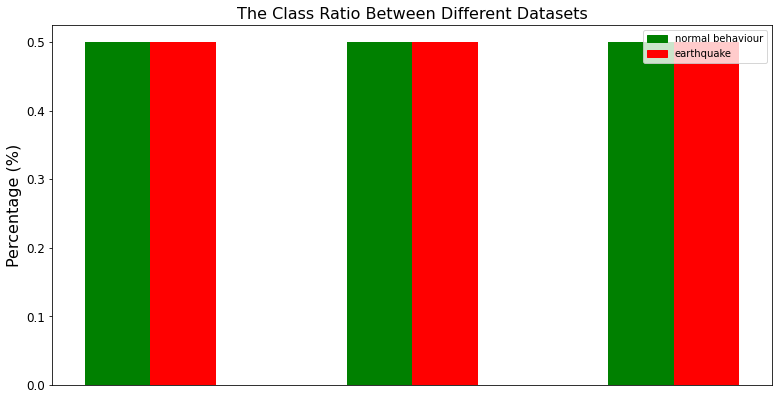

In [76]:
data = [[len(np.where(y_train == 0)[0]) / len(y_train),
        len(np.where(y_validation == 0)[0]) / len(y_validation),
        len(np.where(y_test == 0)[0]) / len(y_test)],
        
       [len(np.where(y_train == 1)[0]) / len(y_train),
        len(np.where(y_validation == 1)[0]) / len(y_validation),
        len(np.where(y_test == 1)[0]) / len(y_test)]]

X = np.arange(3)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
colors = {'normal behaviour':'green', 'earthquake':'red'}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title("The Class Ratio Between Different Datasets", fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks([])

In [1178]:
#x_train = pickle.load(open("../datasets/5hz/x_train.pkl", "rb"))
#y_train = pickle.load(open("../datasets/5hz/y_train.pkl", "rb"))
#
#x_validation = pickle.load(open("../datasets/5hz/x_validation.pkl", "rb"))
#y_validation = pickle.load(open("../datasets/5hz/y_validation.pkl", "rb"))
#
#x_test = pickle.load(open("../datasets/5hz/x_test.pkl", "rb"))
#y_test = pickle.load(open("../datasets/5hz/y_test.pkl", "rb"))

In [1179]:
#x_train.shape, y_train.shape

In [1180]:
#x_validation.shape, y_validation.shape

In [1181]:
#x_test.shape, y_test.shape

In [1182]:
#nan_arr_n, not_58_stations_n, not_61_samples_n = check_nans_incomplete_stations_preprocessed(x_train)
#len(nan_arr_n), len(not_58_stations_n), len(not_61_samples_n)

In [1183]:
#verify_unique_shapes_preprocessed(x_train)

In [1184]:
#nan_arr_n, not_58_stations_n, not_61_samples_n = check_nans_incomplete_stations_preprocessed(x_validation)
#len(nan_arr_n), len(not_58_stations_n), len(not_61_samples_n)

In [1185]:
#verify_unique_shapes_preprocessed(x_validation)

In [1186]:
#nan_arr_n, not_58_stations_n, not_61_samples_n = check_nans_incomplete_stations_preprocessed(x_test)
#len(nan_arr_n), len(not_58_stations_n), len(not_61_samples_n)

In [1187]:
#verify_unique_shapes_preprocessed(x_test)

In [1188]:
#os.getcwd()

In [1189]:
#os.chdir('../../../../../')

In [1190]:
#os.chdir('Volumes/My Passport')

In [1191]:
#e = pickle.load(open("normal_seismic_50hz.pkl", "rb"))

In [1192]:
#e.shape

In [1193]:
#en = e[:1000]

In [1194]:
#en.shape

In [1195]:
#pickle.dump(en, open("n_normal_sesimic_50hz.pkl", "wb"))